In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn import metrics
import statistics
df = pd.read_excel("SupplyChain_TimeSeriesData.xlsx")  #input the file


Importing plotly failed. Interactive plots will not work.


In [2]:
## create copy of df and retain only PC units
df_pc = df.loc[df['Unit'] == 'PC'].copy(deep=True)  

orders = df_pc[df_pc['Confirmation Start Date'] < pd.Timestamp(2017,1,1)]['Order'].unique()
df_pc = df_pc[~df_pc['Order'].isin(orders)]

In [3]:
#Create colummns for actual duration and scheduled duration
df_pc['scheduled_duration_nowkend'] = df_pc.apply(lambda row: pd.bdate_range( row['Schedule Start Date'], row['Schedule Finish Date']).shape[0] \
                                            if not pd.isna(row['Schedule Start Date']) and not pd.isna(row['Schedule Finish Date']) else np.nan, axis=1 )
df_pc['actual_duration_nowkend'] = df_pc.apply(lambda row: pd.bdate_range( row['Confirmation Start Date'], row['Usage Decision Date']).shape[0] \
                                         if not pd.isna(row['Confirmation Start Date']) and not pd.isna(row['Usage Decision Date']) else np.nan, axis=1 )

In [4]:
#Put df in chronological order
df_pc = df_pc.sort_values("Confirmation Start Date", ascending = 1)

#Remove NaN values
df_pc = df_pc.dropna(subset=['Confirmation Start Date', 'Usage Decision Date'])


In [5]:
unique_group = pd.unique(df["Group"])
unique_group.sort()
unique_group
newDataSet = pd.DataFrame()

for value in unique_group:
    group = df_pc.loc[(df["Group"] == value)] #group == 106, 100001064, 100001522, 100001520
    group = group.loc[group["actual_duration_nowkend"] > 0]
   # group.set_index("Confirmation Start Date", inplace = True)
    group = group.sort_values("Confirmation Start Date")
    group["per"] = group['Confirmation Start Date'].dt.to_period("M")
    
    if len(group) > 1:
        three_sigma = statistics.stdev(group['actual_duration_nowkend']) * 3
        group = group[group['actual_duration_nowkend'] <= three_sigma]
    
    
        dates = pd.unique(group["per"])
        # empty is an empty dataframe that I am adding rows to at the end of the for-loop

        for month in dates:
            df_month = group.loc[group["per"] == month]

            #Looking at Outliers
            q1 = df_month.quantile(0.25)[0]
            q2 = df_month.quantile(0.50)[0]
            q3 = df_month.quantile(0.75)[0]

            IQR = q3 - q1
            lower = q1 - 1.5*IQR
            upper = q3 + 1.5*IQR

            temp = df_month[(df_month["actual_duration_nowkend"] < upper)]
            temp['ds'] = df_month.index
            newDataSet = newDataSet.append(temp)

In [6]:
#X: input features
#Y: target variable 

X = newDataSet[['Group', 'MaterialCategory', 'Material', 'Total order quantity', 'Confirmation Start Date',]]
Y = newDataSet['actual_duration_nowkend']

In [7]:
#Training Data for Prophet

pro_df = pd.DataFrame()
pro_df['ds'] = X['Confirmation Start Date']
pro_df['y'] = Y

In [8]:
#Prophet Model with multiple regressors

pro_df['Material'] = X['Material']
pro_df['Group'] = X['Group']
pro_df['MaterialCategory'] = X['MaterialCategory']
pro_df['Total order quantity'] = X['Total order quantity']


pro_df = pro_df.sort_values(by = 'ds')



In [9]:
train_df = pro_df[ : 11690 ].copy()
test_df = pro_df[11690 : ].copy()

In [10]:
r = Prophet(yearly_seasonality = True, daily_seasonality = True)
r.add_regressor('Material')
r.add_regressor('Group')
r.add_regressor('MaterialCategory')
r.add_regressor('Total order quantity')


r.fit(train_df)
#future_r = r.make_future_dataframe(periods = 365)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


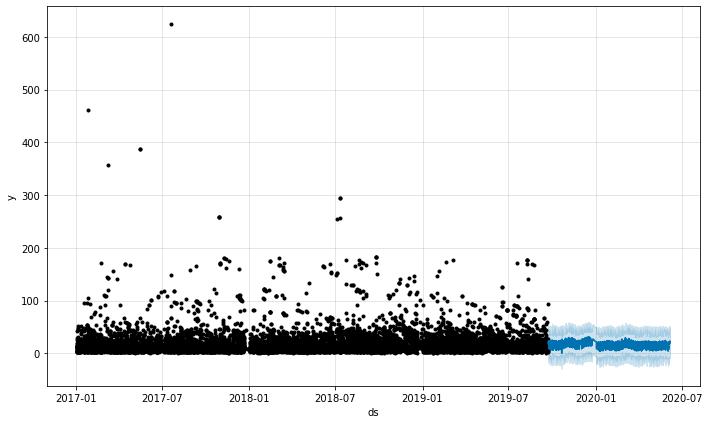

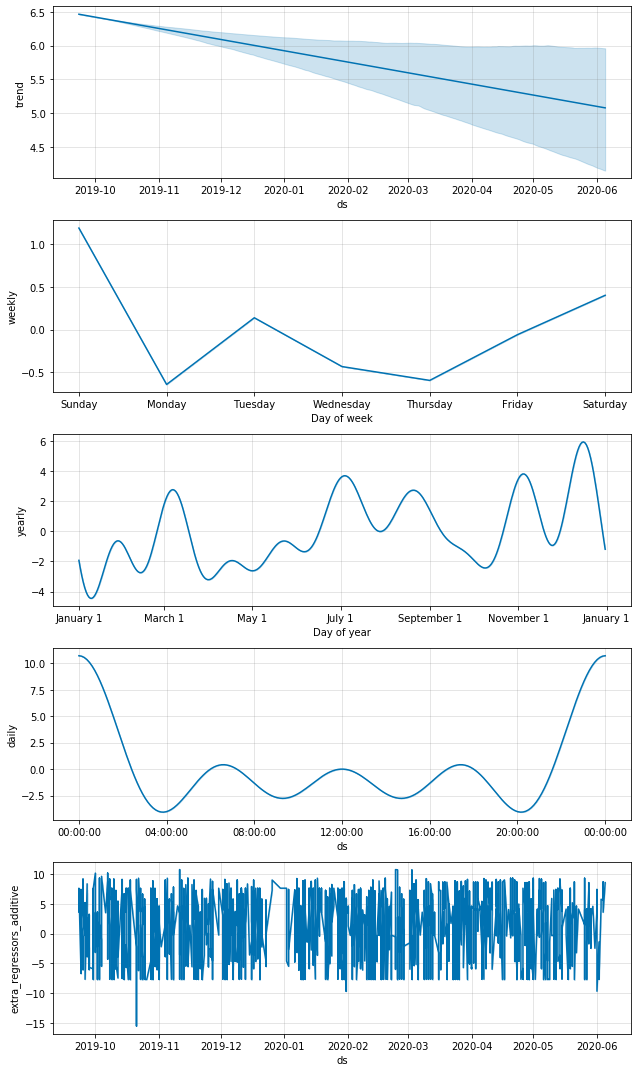

In [11]:
forecast_r = r.predict(test_df) 

fig3 = r.plot(forecast_r) 
fig4 = r.plot_components(forecast_r)

In [12]:
#Calculating Accuracy using MSE 

mse = metrics.mean_squared_error(test_df['y'], forecast_r['yhat'], squared=True)
print(mse)

193.23438848877427


In [13]:
test_df

,ds,y,Material,Group,MaterialCategory,Total order quantity
28232,2019-09-23,44.0,100001529,157,13,3005.0
27365,2019-09-23,12.0,100001958,138,15,18000.0
28231,2019-09-24,32.0,100001536,157,13,6900.0
28205,2019-09-24,13.0,100000753,114,9,688.0
28289,2019-09-24,11.0,100000881,107,9,4200.0
...,...,...,...,...,...,...
33649,2020-06-03,3.0,100001482,140,15,5250.0
34064,2020-06-04,3.0,100002707,157,13,2337.0
34504,2020-06-04,3.0,100001494,151,13,400.0
34503,2020-06-04,3.0,100001482,140,15,14500.0


In [14]:
from datetime import datetime

ds_str = "2020-07-08"
ds = datetime.strptime(ds_str, '%Y-%m-%d')

cols = {'ds': [ds], 'Material' : [100002693] , 'Group' : [119], 'MaterialCategory':[9], 'Total order quantity': 9800 }

future = pd.DataFrame(cols)

In [15]:
forecast = r.predict(future) 

In [16]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Group,Group_lower,Group_upper,Material,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-08,4.8971,-4.333801,49.644993,3.787581,5.998825,0.043822,0.043822,0.043822,6.339704,...,-0.43407,-0.43407,-0.43407,3.383155,3.383155,3.383155,0.0,0.0,0.0,23.048236


In [17]:
df_pc.tail(10)

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date,scheduled_duration_nowkend,actual_duration_nowkend
34305,132692,100000849,B22424,124,5,216.0,PC,216.0,2020-06-01,2020-06-02,2020-06-01,2020-05-28,2020-06-02,2020-06-03,2,3.0
34316,132700,100001489,B22433,106,4,16.0,PC,16.0,2020-05-18,2020-05-22,2020-06-01,2020-06-01,2020-06-03,2020-06-08,5,6.0
34492,132771,100002534,B22504,106,4,32.0,PC,32.0,2020-06-01,2020-06-05,2020-06-02,2020-06-02,2020-06-04,2020-06-05,5,4.0
34502,132776,100001065,B22509,106,4,10.0,PC,10.0,2020-06-08,2020-06-12,2020-06-02,2020-06-02,2020-06-03,2020-06-04,5,3.0
33649,131494,100001482,B21278,140,15,5250.0,PC,5250.0,2020-06-02,2020-06-05,2020-06-03,2020-05-28,2020-06-04,2020-06-05,4,3.0
34450,132303,100002693,B22041,119,9,9800.0,PC,9763.0,2020-05-28,2020-06-04,2020-06-03,2020-06-01,2020-06-04,2020-06-04,6,2.0
34064,132545,100002707,B22277,157,13,2337.0,PC,2336.0,2020-06-04,2020-06-19,2020-06-04,2020-05-30,2020-06-05,2020-06-08,12,3.0
34503,132380,100001482,B22116,140,15,14500.0,PC,14500.0,2020-06-04,2020-06-10,2020-06-04,2020-06-01,2020-06-06,2020-06-08,5,3.0
34504,131493,100001494,B21277,151,13,400.0,PC,399.0,2020-06-05,2020-06-12,2020-06-04,2020-06-03,2020-06-06,2020-06-08,6,3.0
34065,132488,100002706,B22225,157,13,9762.0,PC,9756.0,2020-06-05,2020-06-22,2020-06-05,2020-06-01,2020-06-07,2020-06-08,12,2.0
